In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
import warnings
import joblib
import os
import math
warnings.filterwarnings("ignore")

Best Parameters of Random Forest Ramdomorized
Best Parameters of Random Forest Ramdomorized
Best Params:  {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.2, 'max_depth': 1000, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 1.0116288285798105 | RMSE : 1.3603455167601657 | R2 : 0.7951542289545707 | EV : 0.7951601752123059


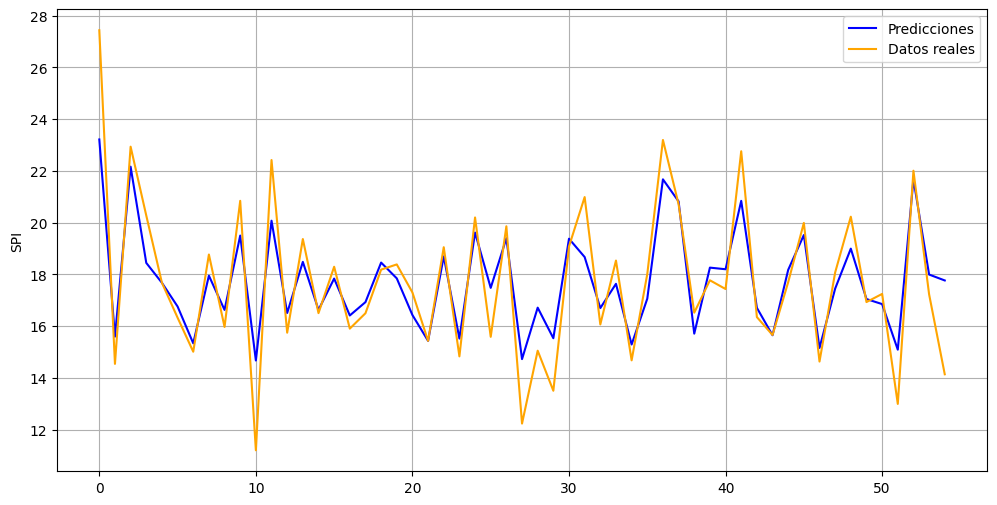

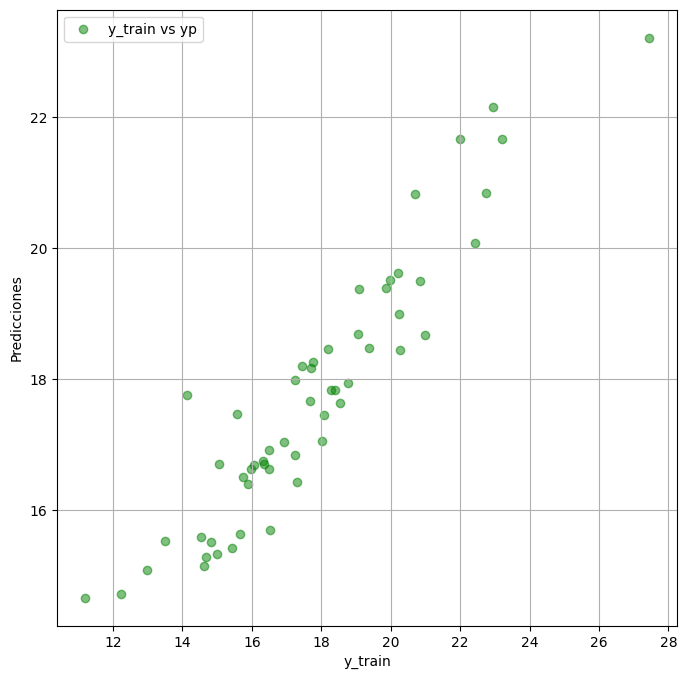

Best Params:  {'n_estimators': 400, 'min_samples_split': 80, 'min_samples_leaf': 16, 'max_features': 0.6, 'max_depth': 50, 'bootstrap': False}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 1.6450227357760103 | RMSE : 2.102513994351093 | R2 : 0.32522953431382084 | EV : 0.32522953431382084


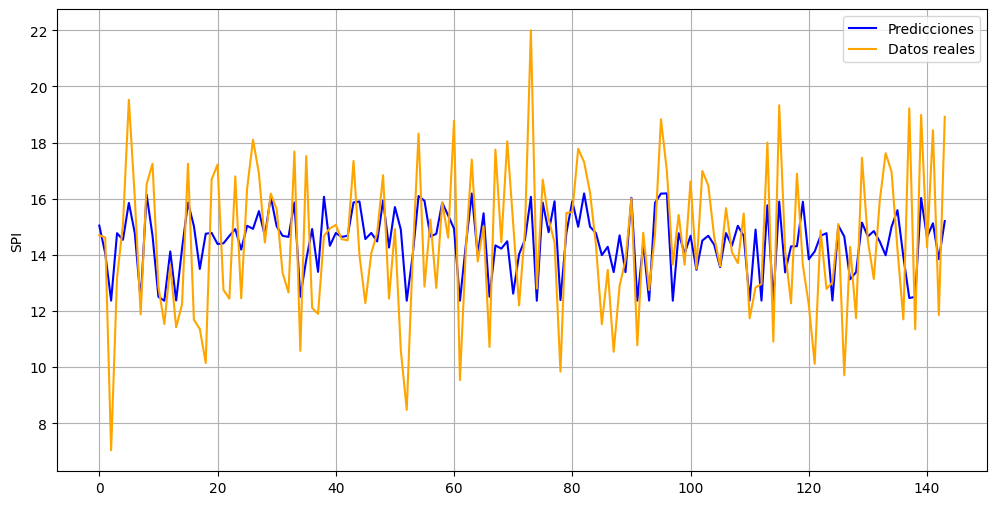

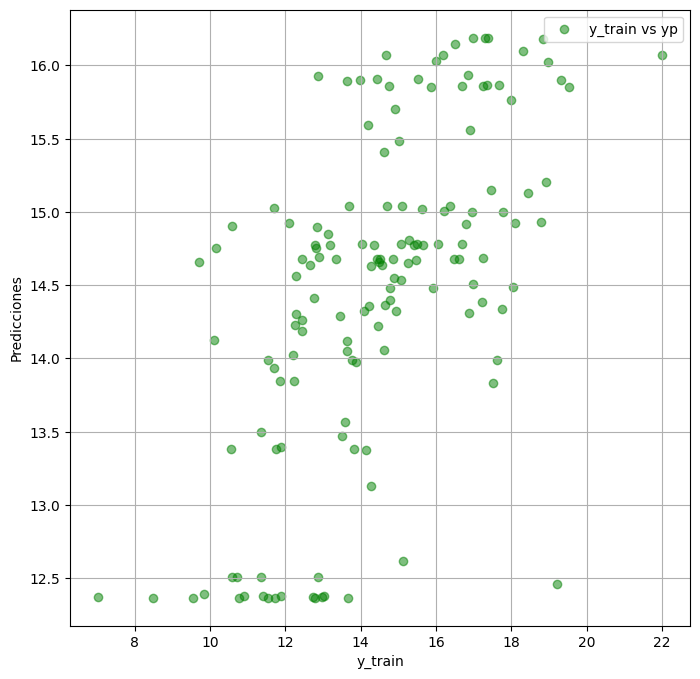

In [205]:
def Grafics_ML(y_train,yp):
        # Primera gráfica de líneas
        fig, ax1 = plt.subplots(figsize=(12, 6))
        t = np.arange(0, len(yp), 1)
        ax1.plot(t, yp, label='Predicciones', color='blue')
        ax1.plot(t, y_train, label='Datos reales', color='orange')
        ax1.set_ylabel('SPI')
        ax1.grid(True)
        ax1.legend()

        # Segunda gráfica de scatter plot
        fig2, ax2 = plt.subplots(figsize=(8, 8))
        ax2.scatter(y_train, yp, label='y_train vs yp', color='green', alpha=0.5)
        ax2.set_xlabel('y_train')
        ax2.set_ylabel('Predicciones')
        ax2.grid(True)
        ax2.legend()
        plt.show()

def Assay_Limit(data,element,ley):
        df1 = data.loc[data[element] >= ley]
        df2 = data.loc[data[element] < ley]
        return df1,df2

def RF_Best_Params(X,y):
        print('Best Parameters of Random Forest Ramdomorized')
        rg = {'bootstrap': [True, False], 
                'max_depth': [10,50,100,500,750,1000,None],
                'max_features': ['auto', 'sqrt','log2',0.2,0.3,0.6,0.9], 
                'min_samples_leaf': [1,2,4,16,32,64,128],
                'min_samples_split': [2,5,10,20,40,80], 
                'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
        
        gsc = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rg, n_iter=100,
                                   cv=5, verbose=0, random_state=42,n_jobs=-1)
        grid_result = gsc.fit(X, y)
        best_params = grid_result.best_params_
        return best_params

def RF_Scoring(X,y,params,root_model,name):
        rfr = RandomForestRegressor(max_depth=params["max_depth"], n_estimators=params["n_estimators"],
                                      min_samples_leaf=params["min_samples_leaf"],max_features= params["max_features"],
                                        min_samples_split=params["min_samples_split"],bootstrap=params["bootstrap"],
                                        verbose=0, warm_start=True,random_state=42,n_jobs=-1)
        print("Best Params: ",params)
        rfr.fit(X, y)
        file_model= name +'.pkl'
        file_model = os.path.join(root_model, file_model)
        joblib.dump(rfr,file_model)

        print("Scoring Analysis and Graphics")
        scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'r2': 'r2','explained_variance': 'explained_variance'}
        scores1 = cross_validate(rfr, X, y, cv=10, scoring=scoring, return_train_score=True)
        print("Random Forest Regression Analysis")
        print("MAE :", abs(scores1['train_abs_error'].mean()), "| RMSE :",
                math.sqrt(abs(scores1['train_squared_error'].mean())),
                "| R2 :", scores1['train_r2'].mean(), "| EV :", scores1['train_explained_variance'].mean())
        yp = rfr.predict(X)
        Grafics_ML(y, yp)


def RF_Model(root,root_model,target):
        df = pd.read_excel(root)
        df1, df2  = Assay_Limit(df,element='Na%',ley=0.5)
        X1 = df1[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
        y1 = df1[target]
        X2 = df2[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
        y2 = df2[target]
        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        # Normalizar los datos
        scaler1 = MinMaxScaler(feature_range=(0,1))
        scaler1.fit(X1_train)
        X1_train = scaler1.transform(X1_train)
        X1_test = scaler1.transform(X1_test)
        file_scaler1= 'scaler_rf1.pkl'
        file_scaler1 = os.path.join(root_model, file_scaler1)
        joblib.dump(scaler1,file_scaler1)

        scaler2 = MinMaxScaler(feature_range=(0,1))
        scaler2.fit(X2_train)
        X2_train = scaler2.transform(X2_train)
        X2_test = scaler2.transform(X2_test)
        file_scaler2= 'scaler_rf2.pkl'
        file_scaler2 = os.path.join(root_model, file_scaler2)
        joblib.dump(scaler2,file_scaler2)
        
        best_params_1 = RF_Best_Params(X1_train,y1_train)
        best_params_2 = RF_Best_Params(X2_train,y2_train)
        
        RF_Scoring(X1_train,y1_train,best_params_1,root_model,name='model_rf1')
        RF_Scoring(X2_train,y2_train,best_params_2,root_model,name='model_rf2')


root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/BWI/'
target = 'BWI'
RF_Model(root,root_model,target)
        
        
# def Model_Predict(root, root_model, ley):
#     df = pd.read_excel(root)[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
#     def Model_1(x):
#         file_model = 'model_rf1.pkl'
#         file_model = os.path.join(root_model, file_model)
#         file_scaler = 'scaler_rf1.pkl'
#         file_scaler = os.path.join(root_model, file_scaler)
#         scaler_s = joblib.load(file_scaler) 
#         model_s = joblib.load(file_model)
#         x_test = scaler_s.transform(x)
#         y_pred = model_s.predict(x_test)
#         return y_pred

#     def Model_2(x):
#         file_model = 'model_rf2.pkl'
#         file_model = os.path.join(root_model, file_model)
#         file_scaler = 'scaler_rf2.pkl'
#         file_scaler = os.path.join(root_model, file_scaler)
#         scaler_s = joblib.load(file_scaler) 
#         model_s = joblib.load(file_model)
#         x_test = scaler_s.transform(x)
#         y_pred = model_s.predict(x_test)
#         return y_pred
    
#     df['Resultado'] = None
#     for index, row in df.iterrows():
#         valor_na = row['Na%']
#         df.at[index, 'Resultado'] = Model_1(row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]) if valor_na >= ley else Model_2(row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']])
#     return df




In [200]:
import pandas as pd
import os
import joblib

def Model_Predict(root, root_model, ley):
    df = pd.read_excel(root)[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]

    def Model_1(x):
        file_model = 'model_rf1.pkl'
        file_model = os.path.join(root_model, file_model)
        file_scaler = 'scaler_rf1.pkl'
        file_scaler = os.path.join(root_model, file_scaler)
        scaler_s = joblib.load(file_scaler) 
        model_s = joblib.load(file_model)
        x_test = scaler_s.transform(x)
        y_pred = model_s.predict(x_test)
        return y_pred

    def Model_2(x):
        file_model = 'model_rf2.pkl'
        file_model = os.path.join(root_model, file_model)
        file_scaler = 'scaler_rf2.pkl'
        file_scaler = os.path.join(root_model, file_scaler)
        scaler_s = joblib.load(file_scaler) 
        model_s = joblib.load(file_model)
        x_test = scaler_s.transform(x)
        y_pred = model_s.predict(x_test)
        return y_pred

    for index, row in df.iterrows():
        valor_na = row['Na%']
        if valor_na >= 0.5:
            x = row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
            result = Model_1(pd.DataFrame(x).transpose())
            df.at[index, 'Resultado'] = result
        else:
            result = Model_2(pd.DataFrame(x).transpose())
            df.at[index, 'Resultado'] = result
    return df

root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/SPI/'
ley =0.5
Model_Predict(root, root_model, ley)

UnboundLocalError: local variable 'x' referenced before assignment

In [206]:
import os
import pandas as pd
import joblib

root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/SPI/'
df = pd.read_excel(root)[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']].head(30)

def Model_1(x):
    root_model = '../04_Model/Hardness/SPI/' # Assuming that the models are in the same directory as your script
    file_model = 'model_rf1.pkl'
    file_model = os.path.join(root_model, file_model)
    file_scaler = 'scaler_rf1.pkl'
    file_scaler = os.path.join(root_model, file_scaler)
    scaler_s = joblib.load(file_scaler) 
    model_s = joblib.load(file_model)
    x_test = scaler_s.transform(x)
    y_pred = model_s.predict(x_test)
    return y_pred

def Model_2(x):
    root_model = '../04_Model/Hardness/SPI/'
    file_model = 'model_rf2.pkl'
    file_model = os.path.join(root_model, file_model)
    file_scaler = 'scaler_rf2.pkl'
    file_scaler = os.path.join(root_model, file_scaler)
    scaler_s = joblib.load(file_scaler) 
    model_s = joblib.load(file_model)
    x_test = scaler_s.transform(x)
    y_pred = model_s.predict(x_test)
    return y_pred

for index, row in df.iterrows():
    valor_na = row['Na%']
    if valor_na >= 0.5:
        x = row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
        result = Model_1(pd.DataFrame(x).transpose())
        df.at[index, 'Resultado'] = result
    else:
        x = row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
        result = Model_2(pd.DataFrame(x).transpose())
        df.at[index, 'Resultado'] = result

df



,Cu%,Mo%,AgPPM,AuPPM,Al%,Ca%,Fe%,Mg%,Na%,S%,Resultado
0,1.419,0.056,5.9,0.7610,0.64,5.28,32.800,2.0,0.03,1.02,83.575970
1,0.417,0.001,9.0,0.3160,6.65,6.40,4.532,1.0,1.67,1.09,115.857496
2,0.206,0.014,2.0,0.0540,3.80,15.00,10.160,3.0,0.38,0.59,75.929046
3,0.955,0.001,7.1,0.4860,2.62,14.60,16.600,2.0,0.08,0.52,81.139910
4,0.171,0.002,1.3,0.0300,1.19,15.00,4.490,2.0,0.02,0.57,59.763888
5,1.711,0.002,1.8,0.7940,1.17,6.26,35.780,2.0,0.05,1.23,71.063388
6,0.190,0.008,0.5,0.1030,3.84,7.86,16.210,3.0,0.47,0.19,81.426161
7,0.425,0.001,2.3,0.6280,2.49,3.85,37.240,2.0,0.29,0.38,64.732819
8,0.254,0.016,1.7,0.1760,2.32,4.53,38.560,3.0,0.43,0.28,81.405128
9,0.310,0.002,1.2,0.1580,3.48,10.11,19.440,3.0,0.69,0.28,108.147373


In [168]:
for index, row in df.iterrows():
    valor_na = row['Na%']
    if valor_na >= 0.5:
        x = row[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
        result = np.array(x)
    print(result)

[3.100e-01 2.000e-03 1.200e+00 1.580e-01 3.480e+00 1.011e+01 1.944e+01
 3.000e+00 6.900e-01 2.800e-01]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[4.170e-01 1.000e-03 9.000e+00 3.160e-01 6.650e+00 6.400e+00 4.532e+00
 1.000e+00 1.670e+00 1.090e+00]
[3.100e-01 2.000e-03 1.200e+00 1.580e-01 3.480e+00 1.011e+01 1.944e+01
 3

In [182]:
g = [3.100e-01, 2.000e-03, 1.200e+00, 1.580e-01, 3.480e+00, 1.011e+01, 1.944e+01, 3.000e+00, 6.900e-01, 2.800e-01]
k = pd.DataFrame(g).transpose()
l = Model_1(k)
l

59.48722290198397

In [98]:
root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/SPI/'
ley = 0.5
target = 'SPI'
g = Model_Predict(root,root_model,ley)

ValueError: Expected 2D array, got 1D array instead:
array=[1.419e+00 5.600e-02 5.900e+00 7.610e-01 6.400e-01 5.280e+00 3.280e+01
 2.000e+00 3.000e-02 1.020e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [48]:
pd.DataFrame(g)

,0
0,"[94.9806964444444, 90.14576471785713, 92.67864..."
1,"[80.71170700396812, 80.1971601571427, 82.57496..."
2,"[94.98069644444442, 90.14576471785713, 92.6786..."
3,"[94.98069644444439, 90.14576471785713, 92.6786..."
4,"[94.98069644444442, 90.14576471785712, 92.6786..."
...,...
245,"[80.71170700396813, 80.19716015714272, 82.5749..."
246,"[80.71170700396813, 80.19716015714269, 82.5749..."
247,"[80.71170700396813, 80.19716015714268, 82.5749..."
248,"[80.71170700396813, 80.1971601571427, 82.57496..."


Best Parameters of Random Forest Ramdomorized
Best Parameters of Random Forest Ramdomorized
Best Params:  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 750, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 0.9377230816712394 | RMSE : 1.288598750442019 | R2 : 0.8162329296809775 | EV : 0.8162461426318905


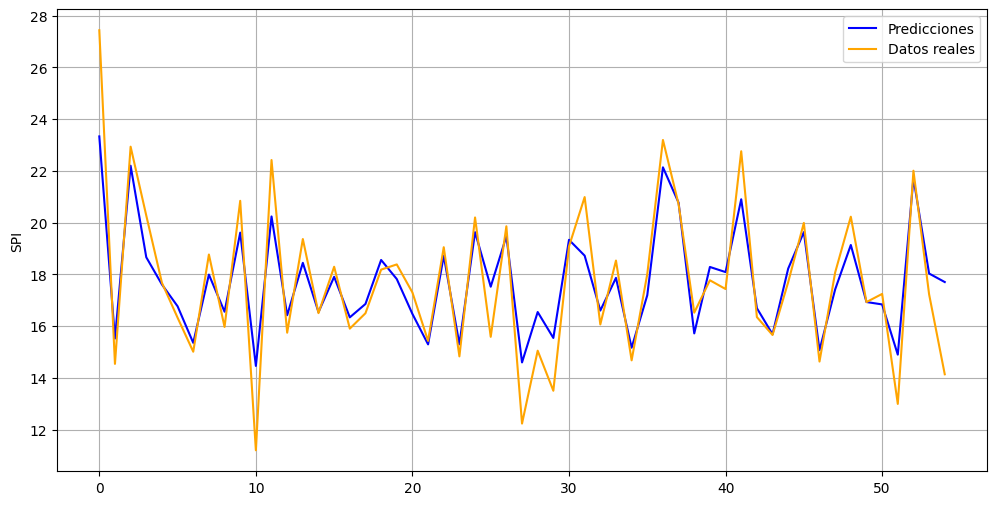

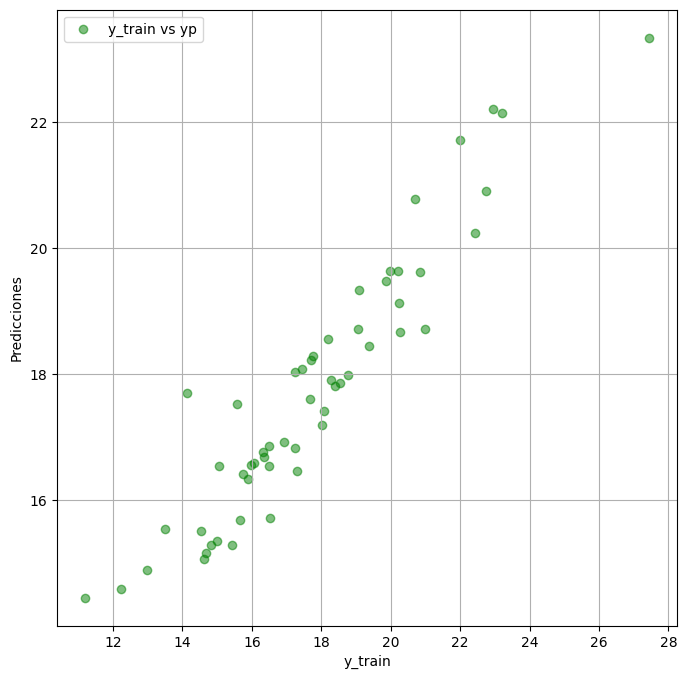

Best Params:  {'n_estimators': 1400, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 0.6, 'max_depth': 500, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 1.3836769072553607 | RMSE : 1.771516574969083 | R2 : 0.5693040601360655 | EV : 0.5693117394938924


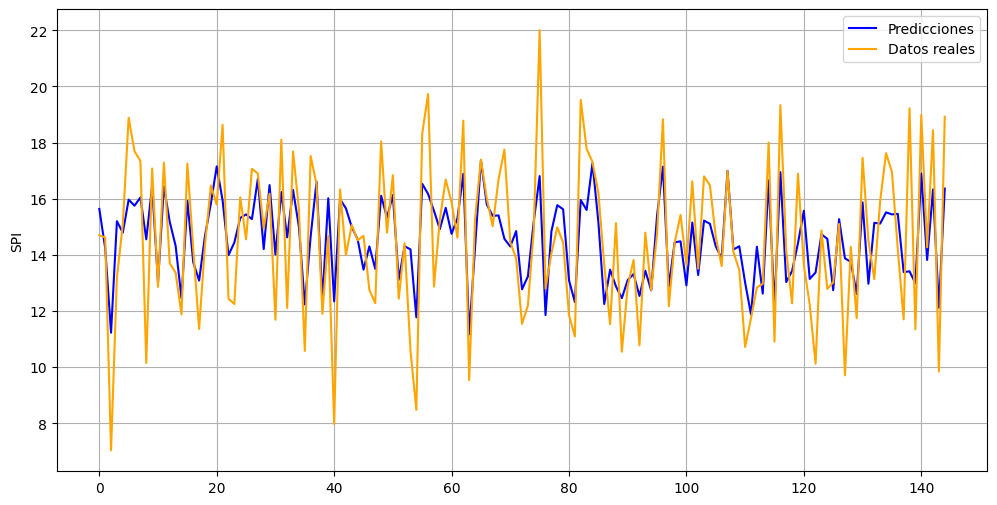

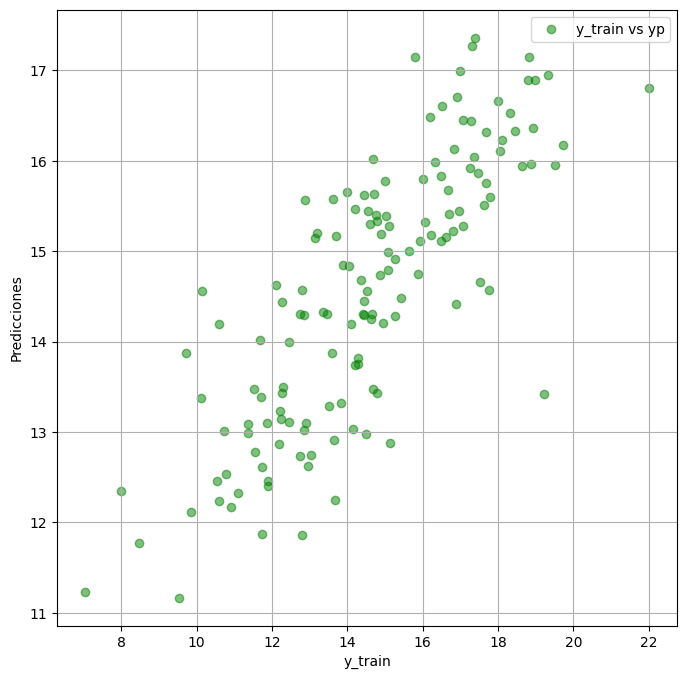

In [25]:
root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/BWI/'
target = 'BWI'
RF_Model(root,root_model,target)

Best Parameters of Random Forest Ramdomorized
Best Parameters of Random Forest Ramdomorized
Best Params:  {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.2, 'max_depth': 1000, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 11.057496362370216 | RMSE : 14.32978102241361 | R2 : 0.7712030073248378 | EV : 0.7712749995102669


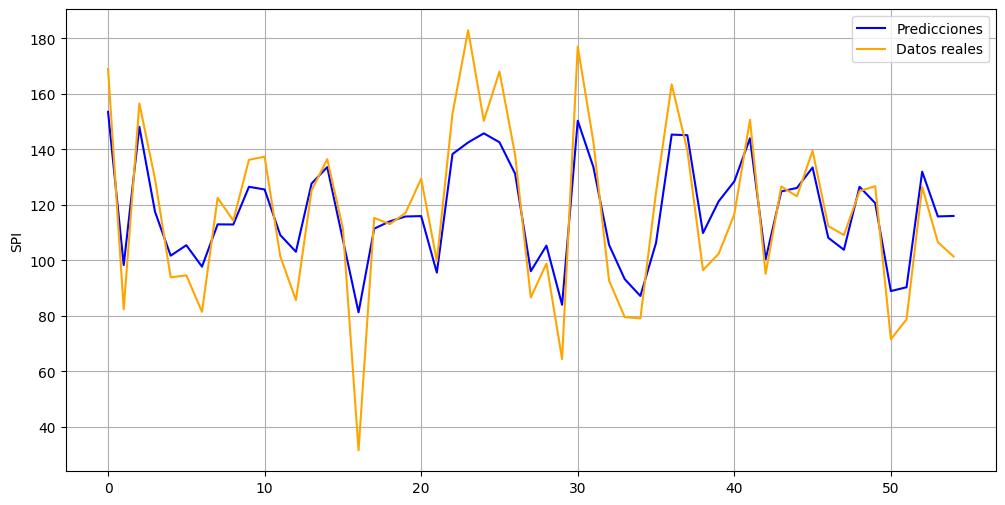

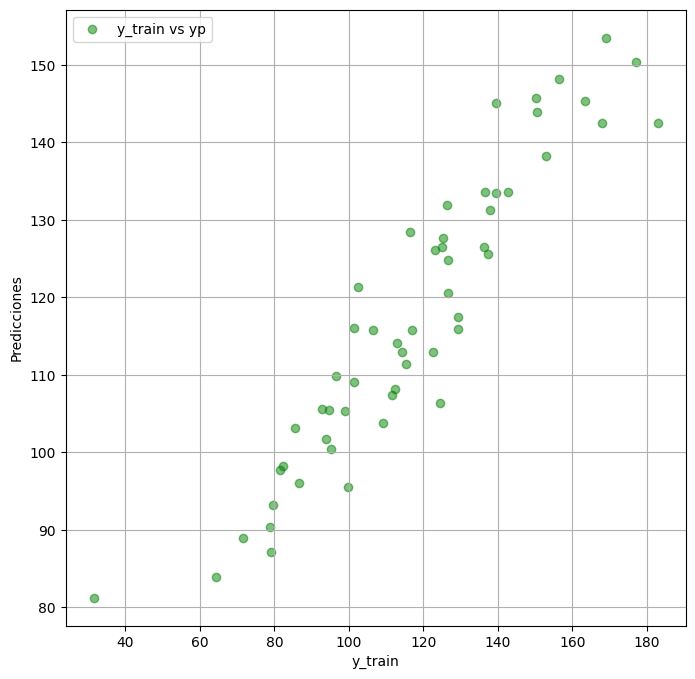

Best Params:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.2, 'max_depth': None, 'bootstrap': False}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 9.471516552171058 | RMSE : 12.087556242927112 | R2 : 0.8492800687985577 | EV : 0.8492800687985577


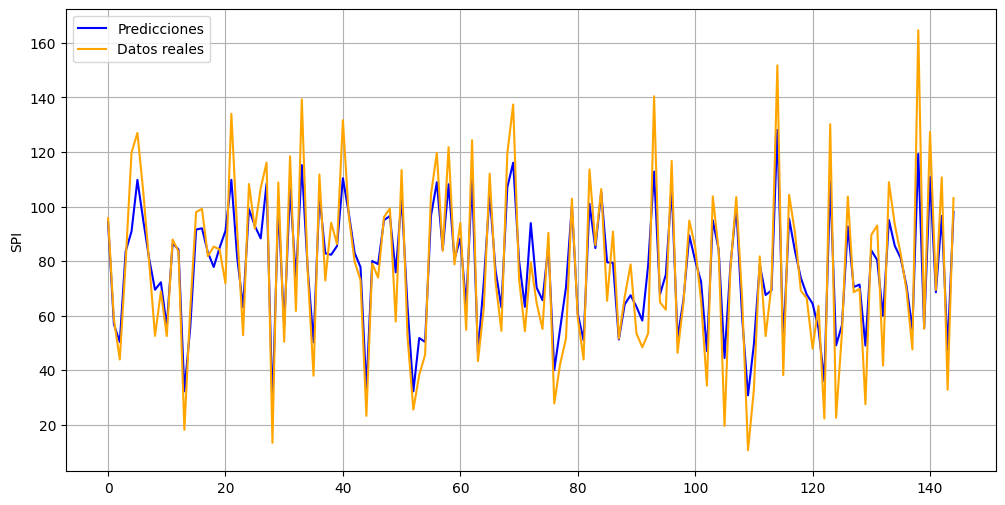

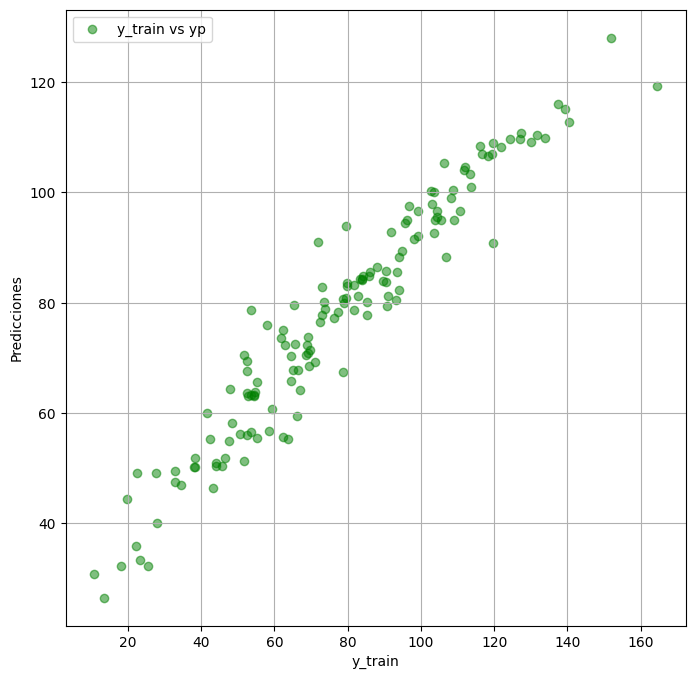

In [26]:
root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/SPI/'
target = 'SPI'
RF_Model(root,root_model,target)

In [ ]:
def Use_RF_Model():
    